we studied about statistical method.. now..

## Inference based method!

problem of Statistical method -> we need long time to calculate SVD.

in case of inference based method, we will use minibatch train method.


### Inference

ex) You say (    ) and I say hello.

(say, and) ---> {MODEL} ----> probability of words



### Word Processing

#### One hot vector

ex)

you = {1, 0, 0, 0, ...}

hello = {0, 0, 1, 0, ...}

length of vector = size of words!

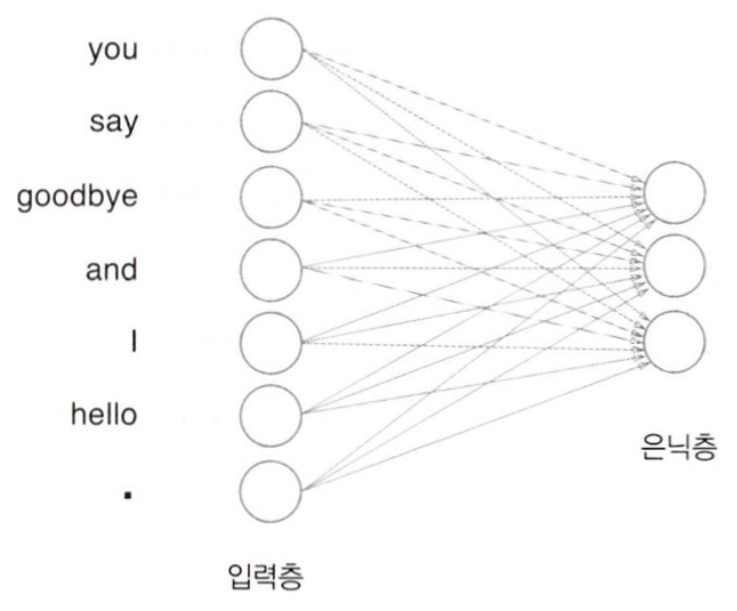

In [1]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)

# FCN matrix dot product!
h = np.matmul(c, W)
print(h)

[[ 0.89609729 -0.98503151  0.96217352]]


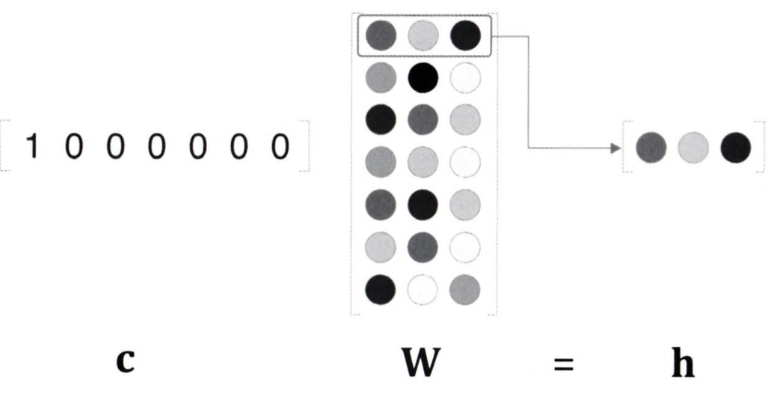

(It is not efficient..)

### CBOW = Continuous bag-of-words

<u>CBOW model: from context, inference target.</u>

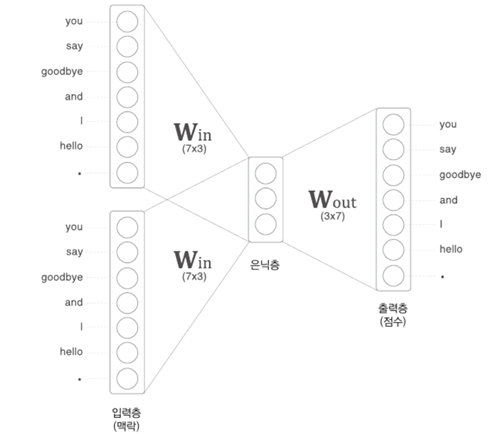

Note) If 'context' gets larger, Input layer size also increases.

in this case, 'window size' = 1. (1 * 2 = 2.)

if 'window size' = 3, input layer size will be 6.

Note 2) hidden layer size should be smaller than input layer size.

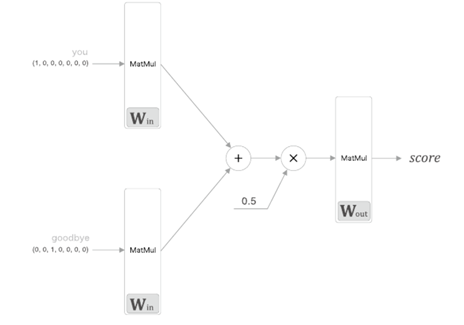

take value of average of input.

In [2]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

In [3]:
import numpy as np

c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# init params
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# make layers with params
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# forward
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-0.54642514  0.45442835  0.19949565  0.7072794  -0.28395127 -0.19211377
   0.66994885]]


with softmax, we can get each word's probability. 

and.. we will train this model by using <u>Softmax with Cross Entropy!</u>

Note) model parameters are influenced by "answer sheet". for example, "sports article", "teen's conversation record"..

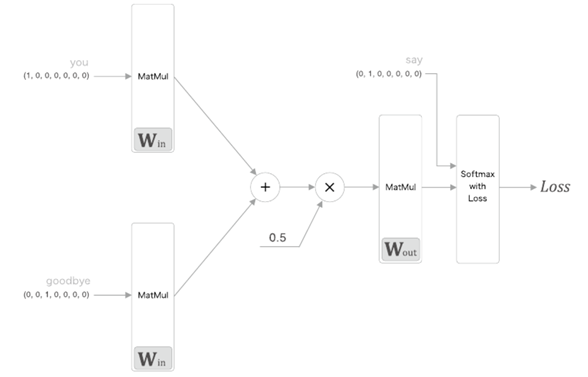

### Dataset

we should make 'context', 'target word'.

##### <u> 'context' = input data, 'target word' = output data.</u>

In [4]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [6]:
text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [7]:
# now we are going to create context - target train data.
def create_contexts_target(corpus, window_size = 1):

    target = corpus[window_size: -window_size] # all target list.

    contexts = []

    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size + 1): # indexing!!
            if t == 0: continue

            cs.append(corpus[idx + t])
        
        contexts.append(cs)

    return np.array(contexts), np.array(target) # input, output set. 

In [8]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


But.. one-hot vector looks more better.

In [9]:
def convert_one_hot(corpus, vocab_size):

    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)

        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [10]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

print(target)

print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


In [11]:
def softmax(x):
    if x.ndim == 2:
        c = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
        return exp_x / sum_exp_x
    
    else:
        c = np.max(x)
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x)
        return exp_x / sum_exp_x

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    if t.size == y.shape[0]:  
        batch_size = y.shape[0]
        return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
    
    else: 
        return -np.sum(t * np.log(y + 1e-7)) / y.shape[0]

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        
        # Integer label
        if self.t.size == self.y.shape[0]:  
            dx = self.y.copy()  
            dx[np.arange(batch_size), self.t] -= 1  
            dx = dx / batch_size
        # One-hot encoding
        else:  
            dx = (self.y - self.t) / batch_size
            
        return dx


In [ ]:
class SimpleCBOW:

    def __init__(self, vocab_size, hidden_size):

        # simplify
        V, H = vocab_size, hidden_size

        # init params
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []

        # collect all params and gradients in single list.
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])

        h = (h0 + h1) * 0.5

        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target) # loss layer = softmax with loss!

        return loss
    
    def backward(self, dout = 1):

        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)

        da *= 0.5

        self.in_layer0.backward(da)
        self.in_layer1.backward(da)

        return None

Train...

$$P(w_t|w_{t-1}, w_{t+1})$$
<center>= modeling of CBOW</center>

In cross Entropy...

$$L = -\sum_{k}^{}t_klogy_k$$

so.. in case of one-hot vector..

$$L = -logP(w_t|w_{t-1},w_{t+1})$$

(because all other t_k = 0!)

and for all words,

$$L = -\frac{1}{T}\sum_{t=1}^{k}logP(w_t|w_{t-1},w_{t+1})$$

word2vec suggests 2 models.

one is CBOW, and another is..

### skip-gram model

: reverse version of CBOW. It reverses target word and context.

so it designs;

$$P(w_{t-1}, w_{t+1}|w_t)$$

$$ = P(w_{t-1}|w_t)P(w_{t+1}|w_t)$$

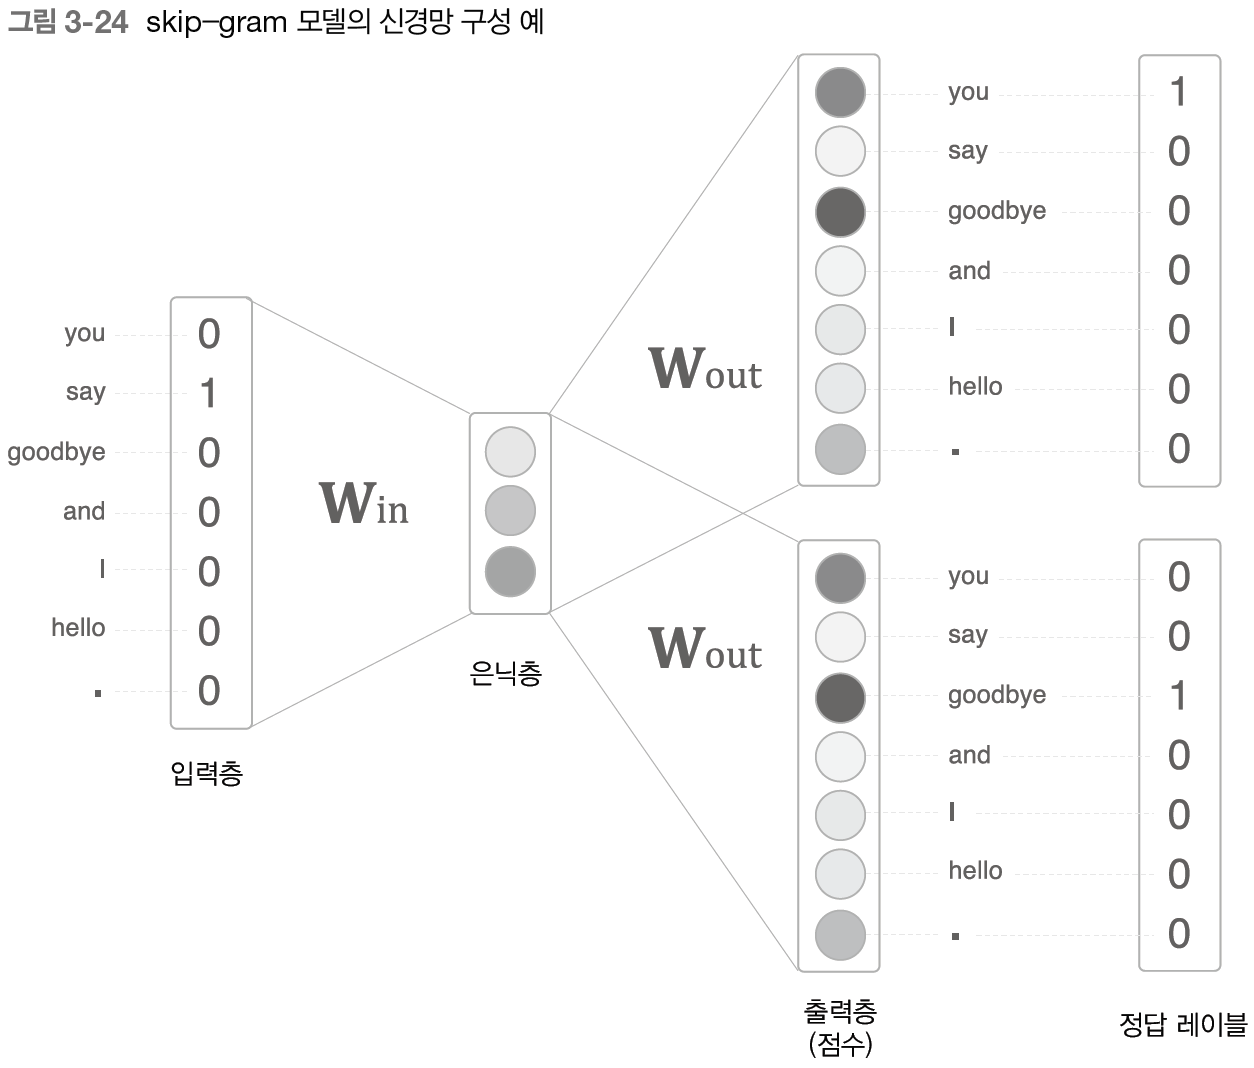

so for all words,

$$L = -\frac{1}{T}\sum_{t=1}^{k}(logP(w_{t-1}|w_t) + logP(w_{t+1}|w_t))$$

Skip gram: each context loss's total sum.


CBOW: single target loss.

#### <u>Generally, in large dataset, "Skip gram"s result is better!</u>

#### because "Skip gram"s problem is more <u>harder..</u>

#### <u>But in case of train speed, "CBOW" is faster!</u>